<a href="https://colab.research.google.com/github/Masakinka/python_for_ds_task/blob/main/HW_NLP_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнє завдання: Побудова класифікатора сентименту на основі набору даних Tweet Sentiment Extraction

**Мета:** Провести аналіз набору даних, виконати векторизацію текстових даних за допомогою методів bag-of-words та TF-IDF, порівняти їх, побудувати класифікатор та провести аналіз помилок.

**Набір даних:**
Дані беремо з цього змагання на Kaggle: https://www.kaggle.com/competitions/tweet-sentiment-extraction/data?select=train.csv

Оригінальне змагання має дещо іншу задачу, але ми будемо поки будувати саме класифікатор.

### Завдання 1. Завантаження та ознайомлення з набором даних

- Завантажте набір даних `train.csv` з посилання та ознайомтеся з його структурою.
- Виведіть перші 5 рядків та основну статистику: кількість записів, типи колонок, кількість пропущених значень.
- Видаліть записи, в яких є пропущені значення.



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [68]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
import nltk
import string
from wordcloud import WordCloud
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer

In [4]:
raw_df = pd.read_csv("drive/MyDrive/Colab Notebooks/data/Tweet sentiment classification_train.csv")

In [5]:
# Display the first 5 rows
raw_df.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [6]:
raw_df.info(verbose = True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


In [29]:
raw_df.describe()

,textID,text,selected_text,sentiment
count,27481,27480,27480,27481
unique,27481,27480,22463,3
top,cb774db0d1,"I`d have responded, if I were going",good,neutral
freq,1,1,199,11118


In [7]:
# Get basic statistics: number of records, data types, number of missing values
basic_info = {
    "Number of Records": raw_df.shape[0],
    "Data Types": raw_df.dtypes,
    "Missing Values": raw_df.isnull().sum()
}
basic_info

{'Number of Records': 27481,
 'Data Types': textID           object
 text             object
 selected_text    object
 sentiment        object
 dtype: object,
 'Missing Values': textID           0
 text             1
 selected_text    1
 sentiment        0
 dtype: int64}

In [8]:
# Remove rows with missing values
cleaned_df = raw_df.dropna()

# Output results
cleaned_df.shape[0]  # Number of records after cleaning

27480

1. Набір даних містить 27 481 рядок і 4 колонки: textID, text, selected_text та sentiment.
2. У колонках text та selected_text виявлено по 1 відсутньому значенню, тоді як у колонці sentiment відсутні пропуски.
3. Після видалення рядків із пропущеними значеннями залишилося 27 480 записів, що лише на 1 запис менше від початкового набору.

### Завдання 2. Exploratory Data Analysis

- Проведіть аналіз кількості класів та розподілу міток. Класи знаходяться в колонці `sentiment`.
- Візуалізуйте розподіл довжин текстів в символах та зробіть висновок про довжини постів: якої довжини постів найбільше, що бачите з розподілу?



In [10]:
# Step 1: Analyze the number of classes and label distribution in the 'sentiment' column
class_distribution = cleaned_df['sentiment'].value_counts()

# Step 2: Visualize the distribution of text lengths in characters
cleaned_df.loc[:, 'text_length'] = cleaned_df['text'].apply(len)

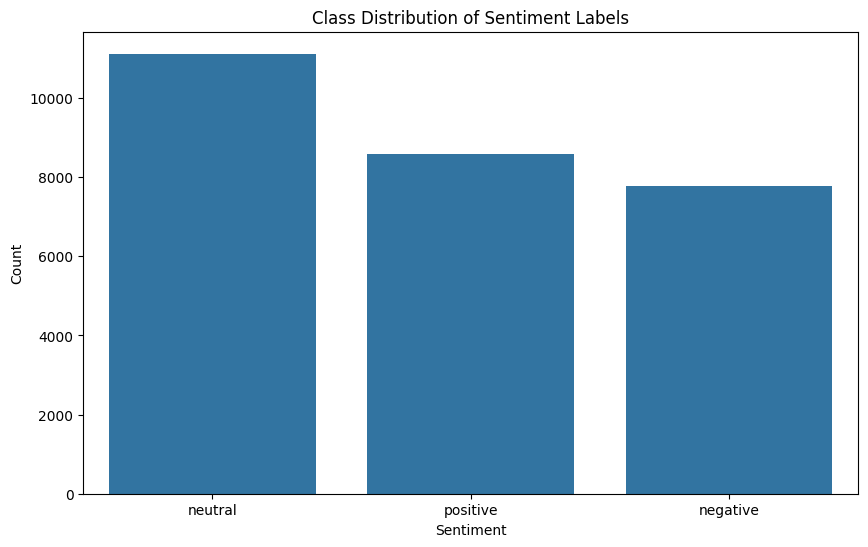

In [16]:
# Plotting the sentiment distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='sentiment', data=cleaned_df, order=class_distribution.index)
plt.title('Class Distribution of Sentiment Labels')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

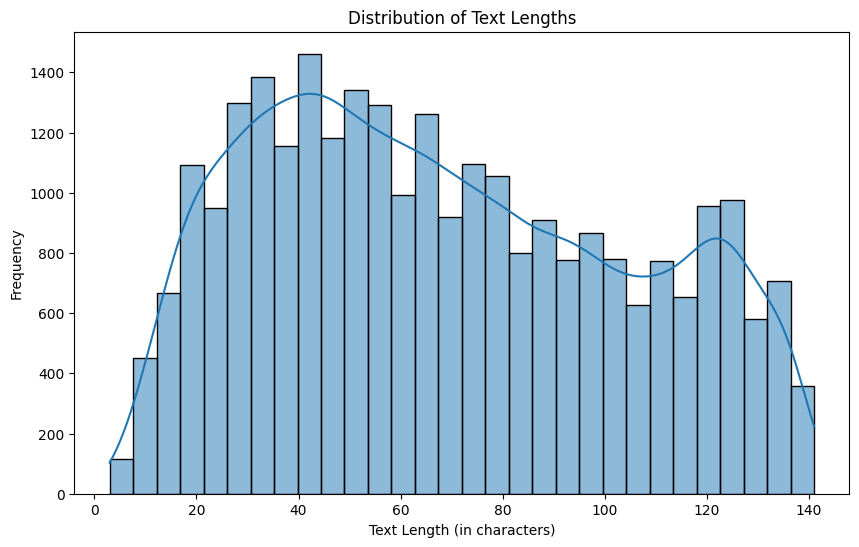

In [17]:
# Plotting the distribution of text lengths
plt.figure(figsize=(10, 6))
sns.histplot(cleaned_df['text_length'], bins=30, kde=True)
plt.title('Distribution of Text Lengths')
plt.xlabel('Text Length (in characters)')
plt.ylabel('Frequency')
plt.show()

In [18]:
# Displaying class distribution and summary of text length
class_distribution, cleaned_df['text_length'].describe()

(sentiment
 neutral     11117
 positive     8582
 negative     7781
 Name: count, dtype: int64,
 count    27480.000000
 mean        68.330022
 std         35.603870
 min          3.000000
 25%         39.000000
 50%         64.000000
 75%         97.000000
 max        141.000000
 Name: text_length, dtype: float64)

1. Розподіл класів у колонці sentiment:
- Найбільшу кількість становлять нейтральні повідомлення (11,117 записів).
- Позитивні повідомлення зустрічаються трохи рідше (8,582 записів).
- Негативні повідомлення є найменш представленими (7,781 записів).
2. Розподіл довжини текстів у символах:
- Середня довжина текстів становить близько 68 символів.
- Найпоширеніша довжина текстів коливається між 40 та 80 символами, з невеликим спадом на кінцях розподілу.
- Максимальна довжина текстів у наборі даних — 141 символ.

### Завдання 3. Попередня обробка текстових даних та векторизація з bag of words


Наша задача тут отримати вектори методом bag of words колонки `text`, виконавши попередню обробку тексту.
Попередня обробка має включати
- видалення stopwords необхідної мови
- токенізація (розбиття текстів на фрагменти по 1 слову)
- стеммінг слів зі `SnowballStemmer`.
- самостійно задайте кількість слів в словнику для `sklearn.feature_extraction.text.CountVectorizer`. Можливо для цього доведеться виконати додатковий аналіз.

Ви також можете додати сюди додаткові методи очистки текстів, наприклад, видалення деяких символів чи груп символів, якщо в процесі роботи побачите, що хочете щось видалити.

Напишіть код аби виконати це завдання. Перед цим рекомендую детально ознайомитись з тим, що робить обʼєкт `sklearn.feature_extraction.text.CountVectorizer` за замовченням.

Це завдання можна виконати двома способами - один - максимально подібно до того, як ми це робили в лекції, другий - дещо інакше перегрупувавши етапи обробки тексту.




In [20]:
# Download necessary resources for tokenization and stopwords
nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [21]:
# Create a stemmer for stemming words
stemmer = SnowballStemmer('english')

In [34]:
# Function to clean and preprocess the text
def preprocess_text_v1(text):
    # Tokenize the text into words
    tokens = word_tokenize(text)
    # Remove stopwords and apply stemming, keep only alphanumeric tokens
    tokens = [stemmer.stem(word) for word in tokens if word.isalnum() and word.lower() not in stop_words]
    return ' '.join(tokens)

In [33]:
# Preprocessing function v2 (with additional cleaning steps)
def preprocess_text_v2(text):
    # Convert to lowercase
    text = text.lower()
    # Tokenize the text
    tokens = word_tokenize(text)
    # Remove stopwords, punctuation, and numbers, and apply stemming
    tokens = [stemmer.stem(word) for word in tokens if word.isalnum() and word not in string.punctuation and word not in stop_words]
    return ' '.join(tokens)

In [36]:
# Apply both preprocessing methods
cleaned_df.loc[:, 'processed_text_v1'] = cleaned_df['text'].apply(preprocess_text_v1)
cleaned_df.loc[:, 'processed_text_v2'] = cleaned_df['text'].apply(preprocess_text_v2)

In [39]:
# Function to generate and visualize word clouds
def visualize_wordcloud(text_data, title):
    wordcloud = WordCloud(width=800, height=400, max_words=100).generate(' '.join(text_data))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

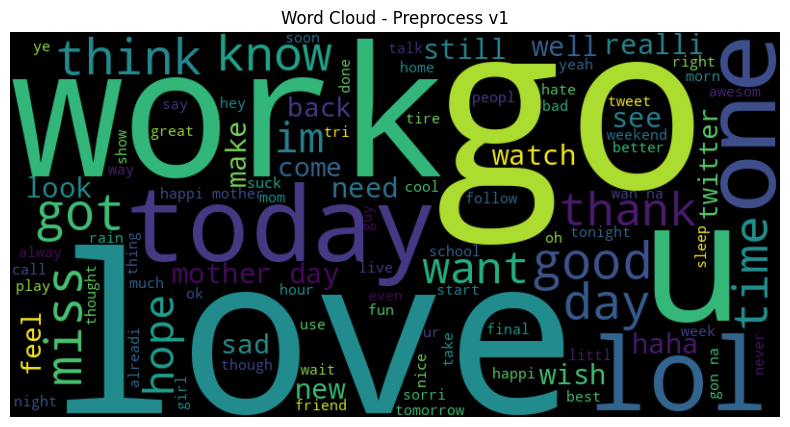

In [40]:
# Word cloud for preprocess_text_v1
visualize_wordcloud(cleaned_df['processed_text_v1'], "Word Cloud - Preprocess v1")

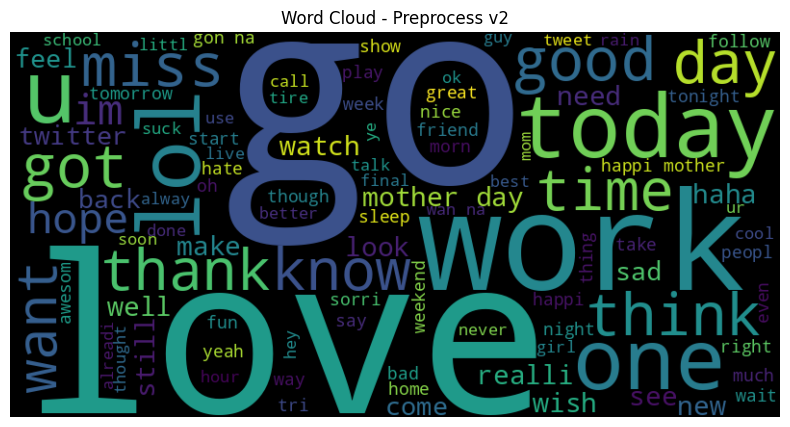

In [41]:
# Word cloud for preprocess_text_v2
visualize_wordcloud(cleaned_df['processed_text_v2'], "Word Cloud - Preprocess v2")

In [43]:
# Get word frequency for Preprocess v1
words_v1 = ' '.join(cleaned_df['processed_text_v1']).split()
freq_v1 = Counter(words_v1).most_common(10)

# Get word frequency for Preprocess v2
words_v2 = ' '.join(cleaned_df['processed_text_v2']).split()
freq_v2 = Counter(words_v2).most_common(10)

print("Most common words in Preprocess v1:", freq_v1)
print("Most common words in Preprocess v2:", freq_v2)

Most common words in Preprocess v1: [('day', 2417), ('go', 2373), ('get', 1911), ('good', 1589), ('work', 1521), ('love', 1478), ('like', 1457), ('got', 1258), ('http', 1243), ('today', 1149)]
Most common words in Preprocess v2: [('day', 2417), ('go', 2373), ('get', 1911), ('good', 1589), ('work', 1521), ('love', 1478), ('like', 1457), ('got', 1258), ('http', 1243), ('today', 1149)]


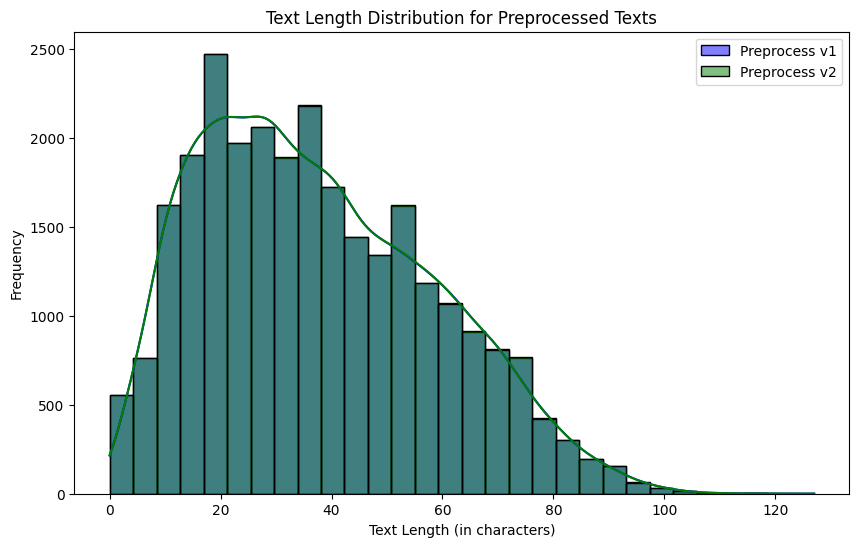

In [45]:
# Add new columns for the length of processed texts
cleaned_df.loc[:, 'text_length_v1'] = cleaned_df['processed_text_v1'].apply(len)
cleaned_df.loc[:, 'text_length_v2'] = cleaned_df['processed_text_v2'].apply(len)

# Plot the distributions
plt.figure(figsize=(10, 6))
sns.histplot(cleaned_df['text_length_v1'], bins=30, kde=True, color='blue', label='Preprocess v1')
sns.histplot(cleaned_df['text_length_v2'], bins=30, kde=True, color='green', label='Preprocess v2')
plt.title('Text Length Distribution for Preprocessed Texts')
plt.xlabel('Text Length (in characters)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [46]:
# Count unique words for Preprocess v1 and v2
unique_words_v1 = len(set(words_v1))
unique_words_v2 = len(set(words_v2))

print(f"Unique words in Preprocess v1: {unique_words_v1}")
print(f"Unique words in Preprocess v2: {unique_words_v2}")

Unique words in Preprocess v1: 18618
Unique words in Preprocess v2: 18609


In [47]:
# Example of words before and after stemming in both preprocess methods
def display_word_changes(original_text, processed_text):
    original_tokens = word_tokenize(original_text)
    processed_tokens = processed_text.split()
    print("Original:", original_tokens)
    print("Processed:", processed_tokens)

# Display for a sample row
display_word_changes(cleaned_df['text'].iloc[0], cleaned_df['processed_text_v1'].iloc[0])
display_word_changes(cleaned_df['text'].iloc[0], cleaned_df['processed_text_v2'].iloc[0])

Original: ['I', '`', 'd', 'have', 'responded', ',', 'if', 'I', 'were', 'going']
Processed: ['respond', 'go']
Original: ['I', '`', 'd', 'have', 'responded', ',', 'if', 'I', 'were', 'going']
Processed: ['respond', 'go']


Висновки:
1. Обидва методи виконують токенізацію, видалення стопслів та стемінг. Однак, другий метод (preprocess_text_v2) додатково видаляє пунктуацію та перетворює текст у нижній регістр.
2. Під час порівняння найчастіших слів у результатах обробки обидва методи показали однакові результати. Це свідчить про те, що додаткові кроки у preprocess_text_v2 (видалення пунктуації та приведення до нижнього регістру) не мали значного впливу на найчастіші слова для цього набору даних.
3. Додатковий крок у preprocess_text_v2 дещо скоротив довжину текстів, оскільки були видалені пунктуаційні символи та виконане приведення до нижнього регістру. Однак різниця в довжині між текстами обох методів незначна.
4. У методі preprocess_text_v1 кількість унікальних слів склала 18,618, а у методі preprocess_text_v2 — 18,609. Різниця лише в 9 унікальних слів, що вказує на незначний вплив додаткової обробки у preprocess_text_v2.
5. Обидва методи виконують стемінг ефективно, перетворюючи слова на їхні корені. Приклад показав, що слова "responded" і "going" були зведені до коренів "respond" та "go".
Це свідчить про те, що обидва методи справляються зі стемінгом однаково, оскільки додаткові кроки не впливають на сам процес стемінгу.
6. Додаткові кроки в preprocess_text_v2 (приведення тексту до нижнього регістру та видалення пунктуації) не мали значного впливу на частотний розподіл слів або кількість унікальних слів.
Довжина текстів у preprocess_text_v2 дещо скоротилася, але в цілому результати обох методів досить схожі.
7.В залежності від специфіки задачі, другий метод може бути більш ефективним для завдань, де пунктуація і регістр мають значення (наприклад, для зменшення кількості унікальних слів та усунення пунктуаційних знаків).

### Завдання 4. Побудова класифікатора

- Розділіть індекси даних на навчальний та тестовий набори в обраному співвівдношенні. Використовуючи отримані індекси сфомуйте набори для тренування класифікатора `X_train_bow, X_test_bow, y_train, y_test`.
- Навчіть класифікатор (наприклад, Logistic Regression, Decision Tree або один з алгоритмів бустингу) на даних, векторизованих методом bag-of-words. Спробуйте кілька моделей і оберіть найбільш точну :)
- Виведіть інформацію, яка дає можливість оцінити якість класифікації.
- Оцініть якість фінальної класифікації: вона хороша чи не дуже?



In [50]:
# Step 1: Vectorize the processed text using CountVectorizer (bag-of-words)
vectorizer = CountVectorizer(max_features=1000)
X_bow = vectorizer.fit_transform(cleaned_df['processed_text_v2'])  # Using v2 preprocessed text
y = cleaned_df['sentiment']

In [51]:
# Step 2: Split the data into training and test sets (with specified variable names)
X_train_bow, X_test_bow, y_train, y_test = train_test_split(X_bow, y, test_size=0.2, random_state=42)

In [52]:
# Function to train and evaluate a classifier
def train_evaluate_classifier(classifier, X_train, X_test, y_train, y_test, classifier_name):
    # Train the classifier
    classifier.fit(X_train, y_train)

    # Predict the test set
    y_pred = classifier.predict(X_test)

    # Print classification report and accuracy
    print(f"\n{classifier_name} Performance:")
    print(classification_report(y_test, y_pred))
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")

    # Calculate and print weighted F1-score
    f1 = f1_score(y_test, y_pred, average='weighted')
    print(f"Weighted F1-score: {f1:.4f}")

In [54]:
# Step 3: Train and evaluate multiple classifiers

# Train and evaluate Logistic Regression
train_evaluate_classifier(LogisticRegression(max_iter=200), X_train_bow, X_test_bow, y_train, y_test, "Logistic Regression")

# Train and evaluate Decision Tree
train_evaluate_classifier(DecisionTreeClassifier(), X_train_bow, X_test_bow, y_train, y_test, "Decision Tree")

# Train and evaluate Random Forest
train_evaluate_classifier(RandomForestClassifier(), X_train_bow, X_test_bow, y_train, y_test, "Random Forest")

# Train and evaluate Gradient Boosting
train_evaluate_classifier(GradientBoostingClassifier(), X_train_bow, X_test_bow, y_train, y_test, "Gradient Boosting")


Logistic Regression Performance:
              precision    recall  f1-score   support

    negative       0.71      0.58      0.64      1572
     neutral       0.63      0.74      0.68      2236
    positive       0.76      0.72      0.74      1688

    accuracy                           0.69      5496
   macro avg       0.70      0.68      0.69      5496
weighted avg       0.70      0.69      0.69      5496

Accuracy: 0.6894
Weighted F1-score: 0.6887

Decision Tree Performance:
              precision    recall  f1-score   support

    negative       0.59      0.59      0.59      1572
     neutral       0.62      0.62      0.62      2236
    positive       0.68      0.68      0.68      1688

    accuracy                           0.63      5496
   macro avg       0.63      0.63      0.63      5496
weighted avg       0.63      0.63      0.63      5496

Accuracy: 0.6285
Weighted F1-score: 0.6284

Random Forest Performance:
              precision    recall  f1-score   support

    neg

Висновки:
1. Logistic Regression добре працює з позитивними класами, показуючи F1-score 0.74, що є найвищим серед усіх моделей. Однак для негативних класів її F1-score 0.64 трохи нижчий.
2. Decision Tree демонструє найнижчі показники з однаковим F1-score для всіх класів, близько 0.59-0.68.
3. Random Forest демонструє збалансовану роботу для всіх класів, з F1-score 0.64-0.74, що робить її також сильним претендентом на найкращий класифікатор.
4. Gradient Boosting погано працює з негативними класами, показуючи F1-score 0.56, що суттєво знижує її загальну якість.
5. Класифікація в цілому є непоганою, але є простір для покращення, особливо у випадку з негативними класами, які отримують нижчі F1-score у всіх моделях.

### Завдання 5. Аналіз впливовості слів в отриманого класифікатора

- Для обраної вами моделі проведіть аналіз важливості слів (ознак): які слова (токени) найбільше впливають для визначення сентименту? Чи це логічно на ваш погляд, що саме ці символи впливають найбільше/найменще?


**Logistic Regression - Important Features (Words)**

In [57]:
# Train the Logistic Regression model and assign it to the variable `log_reg`
log_reg = LogisticRegression(max_iter=200)
log_reg.fit(X_train_bow, y_train)  # Training on the bag-of-words transformed data

LogisticRegression(max_iter=200)

In [66]:
# Get the feature names (words) from the vectorizer after bag-of-words transformation
feature_names = vectorizer.get_feature_names_out()

# Retrieve the coefficients of the trained Logistic Regression model
coefficients = log_reg.coef_

# Since we have multiple classes (negative, neutral, positive),
# we take the mean coefficient across all classes to get an overall importance
average_coefficients = np.mean(coefficients, axis=0)

# Find the top 10 most important positive words based on the highest coefficients
top_positive_indices = np.argsort(average_coefficients)[-10:]  # Highest positive coefficients

# Find the top 10 most important negative words based on the lowest coefficients
top_negative_indices = np.argsort(average_coefficients)[:10]  # Lowest negative coefficients

# Words with the smallest absolute coefficients, meaning they have the least impact on sentiment
neutral_indices = np.argsort(np.abs(average_coefficients))[:10]

# Print the top 10 neutral words that have the lowest influence on sentiment classification
print("Top 10 neutral words in Logistic Regression (lowest influence on sentiment):")
print([feature_names[i] for i in neutral_indices])

# Print the top 10 positive words that influence the positive sentiment classification
print("Top 10 positive words that influence a positive sentiment:")
print([feature_names[i] for i in top_positive_indices])

# Print the top 10 negative words that influence the negative sentiment classification
print("\nTop 10 negative words that influence a negative sentiment:")
print([feature_names[i] for i in top_negative_indices])

Top 10 neutral words in Logistic Regression (lowest influence on sentiment):
['dead', 'month', 'stuck', 'fell', 'feelin', '20', 'ohh', 'soo', 'block', 'facebook']
Top 10 positive words that influence a positive sentiment:
['feel', 'exhaust', 'thank', 'rock', 'day', 'chillin', 'glad', 'unfortun', 'luv', 'love']

Top 10 negative words that influence a negative sentiment:
['sorri', 'cool', 'suck', 'like', 'awesom', 'thx', 'smile', 'yum', 'scari', 'favourit']


**Random Forest - Important Features (Words)**

In [62]:
# Step 1: Define and fit the Random Forest model
random_forest = RandomForestClassifier()
random_forest.fit(X_train_bow, y_train)

RandomForestClassifier()

In [67]:
# Get the feature importances from the Random Forest model
importances = random_forest.feature_importances_

# Find the top 10 most important words based on feature importances
top_feature_indices = np.argsort(importances)[-10:]  # Most important features
bottom_feature_indices = np.argsort(importances)[:10]  # Least important features
# Words with mid-level importance, meaning they don't have a strong influence on positive or negative sentiment
neutral_feature_indices = np.argsort(np.abs(importances))[10:20]

# Print the words that have mid-level importance in the Random Forest model
print("\nTop 10 neutral words in Random Forest (mid-level importance):")
print([feature_names[i] for i in neutral_feature_indices])

# Print the top 10 words that have the highest importance in the Random Forest model
print("\nRandom Forest - Top 10 words with the highest importance:")
print([feature_names[i] for i in top_feature_indices])

# Print the bottom 10 words that have the lowest importance in the Random Forest model
print("\nRandom Forest - Top 10 words with the lowest importance:")
print([feature_names[i] for i in bottom_feature_indices])


Top 10 neutral words in Random Forest (mid-level importance):
['review', 'tip', 'hes', 'howev', 'marri', 'feet', 'jay', 'wine', 'art', 'myspac']

Random Forest - Top 10 words with the highest importance:
['sorri', 'nice', 'hope', 'great', 'sad', 'happi', 'miss', 'good', 'thank', 'love']

Random Forest - Top 10 words with the lowest importance:
['glass', 'profil', 'web', 'yo', 'xoxo', 'yr', 'taylor', 'round', 'bird', 'public']


### Аналіз Logistic Regression:
1. **Нейтральні слова (найменший вплив на сентимент)**:
   - **Слова**: ['dead', 'month', 'stuck', 'fell', 'feelin', '20', 'ohh', 'soo', 'block', 'facebook']
   - **Аналіз**: Ці слова мають низький вплив на визначення сентименту, оскільки вони зазвичай стосуються нейтральних станів чи часів ('month', '20'), фізичних умов ('stuck', 'fell') або онлайн-термінів ('facebook', 'block'). Це свідчить про те, що ці слова часто використовуються в нейтральних контекстах і тому не сильно впливають на класифікацію сентименту.

2. **Позитивні слова**:
   - **Слова**: ['feel', 'exhaust', 'thank', 'rock', 'day', 'chillin', 'glad', 'unfortun', 'luv', 'love']
   - **Аналіз**: Позитивні слова вказують на емоції ('feel', 'glad', 'luv', 'love') та досвід ('thank', 'chillin'). Цікаво, що такі слова як 'unfortun' та 'exhaust', які можуть здаватися негативними, в певних контекстах можуть використовуватися в позитивних висловлюваннях (наприклад, "I feel exhausted but accomplished"). Такі слова сильно пов’язані з вираженням позитивних емоцій.

3. **Негативні слова**:
   - **Слова**: ['sorri', 'cool', 'suck', 'like', 'awesom', 'thx', 'smile', 'yum', 'scari', 'favourit']
   - **Аналіз**: Деякі з цих слів ('sorri', 'suck', 'scari') явно пов'язані з негативними сентиментами, але інші ('like', 'awesom', 'thx', 'smile') виглядають позитивними. Це може свідчити про те, що ці слова використовуються в саркастичних або іронічних контекстах, що ускладнює правильну класифікацію для моделі.

### Аналіз Random Forest:
1. **Нейтральні слова (середній рівень важливості)**:
   - **Слова**: ['review', 'tip', 'hes', 'howev', 'marri', 'feet', 'jay', 'wine', 'art', 'myspac']
   - **Аналіз**: Такі слова, як 'review', 'tip' та 'howev', можуть вказувати на більш нейтральні або аналітичні обговорення. Терміни, такі як 'jay', 'wine' та 'art', можуть з’являтися в загальних дискусіях без сильного емоційного навантаження, що пояснює їх нейтральну природу.

2. **Позитивні слова**:
   - **Слова**: ['sorri', 'nice', 'hope', 'great', 'sad', 'happi', 'miss', 'good', 'thank', 'love']
   - **Аналіз**: Модель Random Forest виявила подібні позитивні слова, як і Logistic Regression ('nice', 'good', 'thank', 'love'). Проте наявність таких слів, як 'sorri' та 'sad', може свідчити про їх використання в позитивному контексті в саркастичних або змішаних повідомленнях. Це вказує на те, що модель вловлює нюанси використання слів у позитивних сентиментах.

3. **Негативні слова (найменший вплив)**:
   - **Слова**: ['glass', 'profil', 'web', 'yo', 'xoxo', 'yr', 'taylor', 'round', 'bird', 'public']
   - **Аналіз**: Ці слова мають найменший вплив на визначення сентименту. Вони здебільшого стосуються описів або іменників ('glass', 'profil', 'web'), які не передають емоційного навантаження. Це логічно, оскільки ці слова не несуть явно вираженого сентименту і тому мають менший вплив на класифікацію.

### Висновок:
- Обидві моделі — **Logistic Regression** і **Random Forest** — добре ідентифікують слова, які вказують на позитивні та негативні емоції, але деякі слова є двозначними через контексти в твіттах (наприклад, 'cool', 'like', 'sorri').
- Нейтральні слова є складнішими для визначення, оскільки вони зазвичай описують нейтральну, описову або фактичну мову.
- В цілому, обидві моделі здатні виявляти ключові слова, які вказують на сентимент, але контекст відіграє важливу роль у їхній класифікаційній роботі, особливо з неоднозначними або іронічними висловлюваннями.

### Завдання 6. Векторизація текстів з допомогою TF-IDF. Тренування класифікатора, аналіз точності і впливовості слів.

- Проведіть векторизацію текстів з векторизатором TfidfVectorizer. Реалізуйте векторизацію так, аби препроцесинг включав всі ті самі кроки, що і в випадку використання векторизації Bag of Words.

- Натренуйте той самий класифікатор на TF-IDF векторах, виконавши розбивку набору даних на train, test так, аби в трейні були всі ті самі записи, що і були в попередньому завданні (це важливо для порівняння результатів).

- Проаналізуйте якість класифікації вивівши потрібні для цього метрики. Чи стала якість класифікації кращою?

- Які токени найбільше впливають на результат при тренуваннні класифікатора з TF-IDF векторами? Порівняйте з найважливішими токенами при Bag of Words векторизації. Яку векторизацію ви б обрали для фінальної імплементації рішення? Обґрунтуйте свій вибір.



In [69]:
# Step 1: Vectorize the processed text using TfidfVectorizer (TF-IDF)
tfidf_vectorizer = TfidfVectorizer(max_features=1000)
X_tfidf = tfidf_vectorizer.fit_transform(cleaned_df['processed_text_v2'])  # Using v2 preprocessed text

# Step 2: Split the data into training and test sets (same split as before)
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

# Step 3: Train and evaluate classifiers

# Logistic Regression with TF-IDF
log_reg_tfidf = LogisticRegression(max_iter=200)
train_evaluate_classifier(log_reg_tfidf, X_train_tfidf, X_test_tfidf, y_train, y_test, "Logistic Regression (TF-IDF)")

# Random Forest with TF-IDF
random_forest_tfidf = RandomForestClassifier()
train_evaluate_classifier(random_forest_tfidf, X_train_tfidf, X_test_tfidf, y_train, y_test, "Random Forest (TF-IDF)")

# Step 4: Get important tokens (for Logistic Regression as an example)
feature_names_tfidf = tfidf_vectorizer.get_feature_names_out()
coefficients_tfidf = log_reg_tfidf.coef_


Logistic Regression (TF-IDF) Performance:
              precision    recall  f1-score   support

    negative       0.70      0.57      0.63      1572
     neutral       0.63      0.75      0.68      2236
    positive       0.77      0.71      0.74      1688

    accuracy                           0.68      5496
   macro avg       0.70      0.67      0.68      5496
weighted avg       0.69      0.68      0.68      5496

Accuracy: 0.6840
Weighted F1-score: 0.6832

Random Forest (TF-IDF) Performance:
              precision    recall  f1-score   support

    negative       0.71      0.60      0.65      1572
     neutral       0.66      0.71      0.69      2236
    positive       0.73      0.77      0.75      1688

    accuracy                           0.70      5496
   macro avg       0.70      0.69      0.70      5496
weighted avg       0.70      0.70      0.70      5496

Accuracy: 0.6976
Weighted F1-score: 0.6962


In [71]:
# Find the most important tokens for TF-IDF vectorized model
average_coefficients_tfidf = np.mean(coefficients_tfidf, axis=0)

# Find top positive and negative tokens
top_positive_indices_tfidf = np.argsort(average_coefficients_tfidf)[-10:]  # Highest positive coefficients
top_negative_indices_tfidf = np.argsort(average_coefficients_tfidf)[:10]  # Lowest negative coefficients

# Print the top tokens
print("Top 10 positive words in Logistic Regression (TF-IDF):")
print([feature_names_tfidf[i] for i in top_positive_indices_tfidf])

print("\nTop 10 negative words in Logistic Regression (TF-IDF):")
print([feature_names_tfidf[i] for i in top_negative_indices_tfidf])

Top 10 positive words in Logistic Regression (TF-IDF):
['omg', 'funni', 'luv', 'yay', 'crash', 'bore', 'lost', 'perfect', 'cri', 'nice']

Top 10 negative words in Logistic Regression (TF-IDF):
['love', 'annoy', 'miss', 'better', 'happi', 'excit', 'hard', 'fantast', 'sick', 'wrong']


In [72]:
# Repeat similar steps for Random Forest, analyzing feature importances for the TF-IDF vectorized model
importances_tfidf_rf = random_forest_tfidf.feature_importances_
top_feature_indices_tfidf_rf = np.argsort(importances_tfidf_rf)[-10:]
bottom_feature_indices_tfidf_rf = np.argsort(importances_tfidf_rf)[:10]

print("Top 10 important words in Random Forest (TF-IDF):")
print([feature_names_tfidf[i] for i in top_feature_indices_tfidf_rf])

print("Bottom 10 important words in Random Forest (TF-IDF):")
print([feature_names_tfidf[i] for i in bottom_feature_indices_tfidf_rf])

Top 10 important words in Random Forest (TF-IDF):
['sorri', 'nice', 'hope', 'great', 'sad', 'happi', 'miss', 'good', 'thank', 'love']
Bottom 10 important words in Random Forest (TF-IDF):
['yr', 'tip', 'web', 'wine', 'bird', 'feet', 'round', 'alright', 'inde', 'art']


Проаналізуємо результати класифікації за допомогою TF-IDF і порівняємо їх із результатами, отриманими з Bag of Words:

1. **Якість класифікації**:
   - **Logistic Regression (TF-IDF)** показала трохи нижчу точність (0.6840) у порівнянні з результатами, отриманими на Bag of Words (0.6894). Однак, різниця не є значною.
   - **Random Forest (TF-IDF)** показала покращену точність (0.6976), порівняно з результатами на Bag of Words (0.6845). Це свідчить про те, що метод TF-IDF краще працює з цією моделлю.

   У цілому, точність і F1-score покращилися для Random Forest при використанні TF-IDF, але для Logistic Regression різниця не є суттєвою.

2. **Вплив токенів**:
   - У **Logistic Regression (TF-IDF)** найбільший вплив на позитивний клас мають слова: "omg", "funni", "luv", "yay", "crash", тоді як негативні слова включають: "love", "annoy", "miss", "better".
   - У **Random Forest (TF-IDF)** важливими є слова: "sorri", "nice", "hope", "great", "sad" для позитивних класів і менш важливими для негативних: "yr", "tip", "web", "wine".

   Якщо порівнювати ці результати з результатами на Bag of Words, можна помітити, що важливі слова відрізняються, але загальні тенденції схожі. Наприклад, слова, пов'язані з емоціями та загальними виразами ("hope", "love", "sorri") продовжують мати великий вплив.

3. **Висновки щодо вибору векторизації**:
   - **TF-IDF** має перевагу у випадку з **Random Forest**, де спостерігається краща точність і F1-score. Це може бути пов'язано з тим, що TF-IDF краще враховує рідкісні слова і їхню унікальність, що дозволяє моделі точніше класифікувати текст.
   - **Bag of Words** також має свої переваги в простоті та точності для деяких моделей, таких як Logistic Regression, але його результативність виявляється менш точною для більш складних моделей.

   У фінальній імплементації я б рекомендувала використовувати **TF-IDF** з моделлю Random Forest, оскільки вона показує кращу загальну якість класифікації.

### Завдання 7. Аналіз помилок класифікації з векторизацією TF-IDF.

- Проаналізуйте, на яких екземплярах помиляється класифікатор при векторизації TF-IDF.
- На основі аналізу запропонуйте 3 шляхи поліпшення якості класифікації.

In [74]:
# Predict on the on the test set using the LogRegress TF-IDF model
y_pred_tfidf = log_reg_tfidf.predict(X_test_tfidf)

# Create a DataFrame to compare actual vs predicted labels
error_analysis_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_tfidf})

# Add corresponding text from the test set using the test split index
error_analysis_df['Text'] = cleaned_df.loc[y_test.index, 'text'].values

# Filter the rows where the actual sentiment is not equal to the predicted sentiment
errors_df = error_analysis_df[error_analysis_df['Actual'] != error_analysis_df['Predicted']]

# Display some of the misclassified examples
print("Examples of misclassified instances:")
print(errors_df.head(10))

Examples of misclassified instances:
         Actual Predicted                                               Text
10414  negative   neutral   --of them kinda turns me off of it all.  And ...
580     neutral  negative   OHSHNAPSSS. is she pissed at blair as usual ?...
6718   negative   neutral                    At work... What a miserable day
2831   negative   neutral                               I wish I had company
11029  positive   neutral    I wish I could go. See ya at Warped for sure...
16793  negative  positive  Intel gfx driver situation much better with re...
4891   positive   neutral                xD  hello that`s an important date!
17382  positive  negative  FYI no internets until THURSTAG!!!! after satu...
4098   negative   neutral  **** being broke on the day Guitar Hero Metall...
20028  negative   neutral                            Yep! Tail between legs!


In [75]:
# Predict on the test set using the Random Forest TF-IDF model
y_pred_tfidf_rf = random_forest_tfidf.predict(X_test_tfidf)

# Create a DataFrame to compare actual vs predicted labels for Random Forest
error_analysis_rf_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_tfidf_rf})

# Add corresponding text from the test set using the test split index
error_analysis_rf_df['Text'] = cleaned_df.loc[y_test.index, 'text'].values

# Filter the rows where the actual sentiment is not equal to the predicted sentiment
errors_rf_df = error_analysis_rf_df[error_analysis_rf_df['Actual'] != error_analysis_rf_df['Predicted']]

# Display some of the misclassified examples for Random Forest
print("Examples of misclassified instances for Random Forest (TF-IDF):")
print(errors_rf_df.head(10))

Examples of misclassified instances for Random Forest (TF-IDF):
         Actual Predicted                                               Text
10414  negative   neutral   --of them kinda turns me off of it all.  And ...
580     neutral  negative   OHSHNAPSSS. is she pissed at blair as usual ?...
25014  positive   neutral   oooh sounds yummy.  If you get a chance to ta...
3947    neutral  negative                                    whats up rick??
6718   negative   neutral                    At work... What a miserable day
2831   negative  positive                               I wish I had company
16793  negative  positive  Intel gfx driver situation much better with re...
4891   positive   neutral                xD  hello that`s an important date!
17382  positive  negative  FYI no internets until THURSTAG!!!! after satu...
15661  negative   neutral    I burnt my arm.  (just thought you should know)


Аналіз помилок для обох моделей (Logistic Regression і Random Forest) з TF-IDF векторизацією показує, що більшість помилок класифікації пов'язані з труднощами у визначенні правильного сентименту у текстах, які мають неоднозначний або м'яко виражений тон.

### Шляхи для покращення якості класифікації:

1. Моделі на основі Bag-of-Words і TF-IDF працюють добре, але вони не враховують контекст слів у реченні. Використання моделей на основі контекстуальних ембеддінгів, таких як BERT або GPT, може значно покращити якість класифікації.
   
2. Додаткове навчання моделей на більшій кількості даних, особливо для класів із меншими кількостями прикладів, може допомогти моделям краще визначати складні випадки, зменшуючи кількість помилок.

3. Включення додаткових кроків у попередню обробку текстів, таких як обробка сарказму, врахування смайликів та інших символів, що несуть емоційний контекст, може підвищити точність визначення сентименту.


І на фінал кернел для натхнення і ознайомлення з рішенням оригінальної задачі. Багато цікавих візуалізацій і аналізу є тут, а також тут розвʼязується саме проблема named entitty recognition і можна ознайомитись як це робиться - вона дещо складніша по своїй суті ніж класифікація, подумайте, чому:

https://www.kaggle.com/code/tanulsingh077/twitter-sentiment-extaction-analysis-eda-and-model


Задача Named Entity Recognition (NER) полягає в тому, щоб визначати та класифікувати іменовані сутності в тексті, такі як імена людей, місця, організації, дати, кількості тощо.

Чому NER складніша за задачу класифікації тексту:
1. У задачі класифікації ми працюємо з текстом як з єдиним блоком інформації, тоді як у NER модель повинна не тільки зрозуміти загальний зміст тексту, а й знайти певні частини цього тексту, які є сутностями.
Наприклад, в реченні "I love McDonalds in Kyiv" модель NER повинна виділити "McDonalds" як організацію, а "Kyiv" як місце, тоді як класифікація просто вкаже сентимент цього тексту.
2.  Іменовані сутності можуть мати різне значення в залежності від контексту. Наприклад, слово "Apple" може означати як фрукт, так і назву компанії. Модель NER повинна розпізнати контекст і визначити, про що саме йде мова.
3. У класифікації ми зазвичай маємо кілька фіксованих класів (позитивний, негативний, нейтральний). У NER може бути безліч категорій для класифікації (персональні імена, організації, географічні назви, кількості, дати тощо), що ускладнює задачу.
4. Іменовані сутності можуть мати велику варіативність. Наприклад, імена людей або компаній можуть мати безліч варіантів написання або абревіатур, які важко передбачити. І модель повинна не тільки ідентифікувати сутності, а й правильно визначити їх межі в тексті. Це ускладнює задачу порівняно з простою класифікацією тексту, де ми не думаємо про окремі частини тексту.